In [1]:
import os
import sys
import random
import shutil
import logging
import argparse
import subprocess
from time import time

import numpy as np
import torch

from test import test
from lib.config import Config
from utils.evaluator import Evaluator
import CLR as CLR
import OneCycle as OneCycle

In [2]:
def update_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr

def update_mom(optimizer, mom):
    for g in optimizer.param_groups:
        g['momentum'] = mom

## Find Cyclic Learning Rates

total annos, 80138
max points: 173
max lanes: 10
Transforming annotations...
Done.
Loaded pretrained weights for efficientnet-b0
Starting training.
Epoch [1/1000], Step [10/2505], Loss: 60.2309 (conf: 0.7044, lower: 0.4351, upper: 0.4392, poly: 57.9624, cls_loss: 0.6899), s/iter: 0.8459, lr: 1.1e-05
Epoch [1/1000], Step [20/2505], Loss: 44.4820 (conf: 0.7013, lower: 0.4472, upper: 0.4053, poly: 42.2182, cls_loss: 0.7100), s/iter: 0.7536, lr: 1.1e-05
Epoch [1/1000], Step [30/2505], Loss: 28.3628 (conf: 0.7048, lower: 0.3787, upper: 0.3875, poly: 26.1877, cls_loss: 0.7042), s/iter: 0.6848, lr: 1.2e-05
Epoch [1/1000], Step [40/2505], Loss: 28.9453 (conf: 0.7049, lower: 0.3948, upper: 0.3843, poly: 26.7743, cls_loss: 0.6868), s/iter: 0.6626, lr: 1.3e-05
Epoch [1/1000], Step [50/2505], Loss: 28.6218 (conf: 0.6973, lower: 0.2755, upper: 0.3698, poly: 26.5823, cls_loss: 0.6968), s/iter: 0.6468, lr: 1.4e-05
Epoch [1/1000], Step [60/2505], Loss: 25.7807 (conf: 0.7039, lower: 0.2802, upper: 0.32

Epoch [1/1000], Step [540/2505], Loss: 14.4591 (conf: 0.6496, lower: 0.0325, upper: 0.0942, poly: 13.0398, cls_loss: 0.6430), s/iter: 0.5613, lr: 3.2e-04
Epoch [1/1000], Step [550/2505], Loss: 14.5540 (conf: 0.6505, lower: 0.0364, upper: 0.0823, poly: 13.1169, cls_loss: 0.6678), s/iter: 0.5649, lr: 3.4e-04
Epoch [1/1000], Step [560/2505], Loss: 20.4656 (conf: 0.6526, lower: 0.0399, upper: 0.0856, poly: 19.0355, cls_loss: 0.6519), s/iter: 0.5766, lr: 3.7e-04
Epoch [1/1000], Step [570/2505], Loss: 14.4387 (conf: 0.6564, lower: 0.0487, upper: 0.0934, poly: 12.9742, cls_loss: 0.6659), s/iter: 0.5787, lr: 3.9e-04
Epoch [1/1000], Step [580/2505], Loss: 13.9631 (conf: 0.6591, lower: 0.0640, upper: 0.1099, poly: 12.4784, cls_loss: 0.6517), s/iter: 0.5875, lr: 4.2e-04
Epoch [1/1000], Step [590/2505], Loss: 17.9099 (conf: 0.6532, lower: 0.0260, upper: 0.0783, poly: 16.5022, cls_loss: 0.6503), s/iter: 0.5835, lr: 4.5e-04
Epoch [1/1000], Step [600/2505], Loss: 20.6854 (conf: 0.6454, lower: 0.0151,

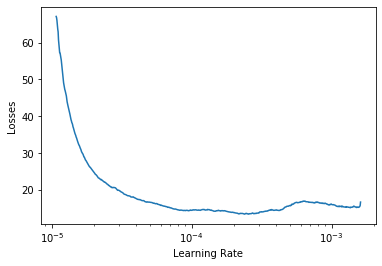

In [3]:
os.environ["CUDA_VISIBLE_DEVICES"]="7"
cfg = Config("jst_b0.yaml")

# Set up seeds
torch.manual_seed(cfg['seed'])
np.random.seed(cfg['seed'])
random.seed(cfg['seed'])

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Get data sets
train_dataset = cfg.get_dataset("train")

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyper parameters
num_epochs = cfg["epochs"]
batch_size = cfg["batch_size"]

# Model
model = cfg.get_model().to(device)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=8)


# Get initial train state
starting_epoch = 1
optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.95, weight_decay=1e-5)
clr = CLR.CLR(optimizer, len(train_loader))

# Train the model
criterion_parameters = cfg.get_loss_parameters()
criterion = model.loss
total_step = len(train_loader)
ITER_LOG_INTERVAL = cfg['iter_log_interval']
ITER_TIME_WINDOW = cfg['iter_time_window']
MODEL_SAVE_INTERVAL = cfg['model_save_interval']
t0 = time()
total_iter = 0
iter_times = []
print("Starting training.")

running_loss = 0.
avg_beta = 0.98
accum_loss = 0
for i, (images, labels, img_idxs) in enumerate(train_loader):
    total_iter += 1
    iter_t0 = time()
    images = images.to(device)
    labels = labels.to(device)

    # Forward pass
    outputs = model(images, epoch=1)
    loss, loss_dict_i = criterion(outputs, labels, **criterion_parameters)
    accum_loss += loss.item()
    
    running_loss = avg_beta * running_loss + (1-avg_beta) *loss.item()
    smoothed_loss = running_loss / (1 - avg_beta**(i+1))
    lr = clr.calc_lr(smoothed_loss)
    if lr == -1 :
        break
    update_lr(optimizer, lr)   

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    iter_times.append(time() - iter_t0)
    if len(iter_times) > 100:
        iter_times = iter_times[-ITER_TIME_WINDOW:]
    if (i + 1) % ITER_LOG_INTERVAL == 0:
        loss_str = ', '.join(
            ['{}: {:.4f}'.format(loss_name, loss_dict_i[loss_name]) for loss_name in loss_dict_i])
        print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f} ({}), s/iter: {:.4f}, lr: {:.1e}".format(
            1,
            num_epochs,
            i + 1,
            total_step,
            loss.item(),
            loss_str,
            np.mean(iter_times),
            optimizer.param_groups[0]["lr"],
        ))

clr.plot()

## Training with One Cycle Policy

In [3]:
def save_train_state(path, model, optimizer, epoch):
    train_state = {
        'model': model.state_dict(),
        'optimizer': optimizer.state_dict(),
        'epoch': epoch
    }

    torch.save(train_state, path)

def setup_exp_dir(exps_dir, exp_name, cfg_path):
    dirs = ["models"]
    exp_root = os.path.join(exps_dir, exp_name)

    for dirname in dirs:
        os.makedirs(os.path.join(exp_root, dirname), exist_ok=True)

    shutil.copyfile(cfg_path, os.path.join(exp_root, 'config.yaml'))

    return exp_root

def get_exp_train_state(exp_root):
    models_dir = os.path.join(exp_root, "models")
    models = os.listdir(models_dir)
    last_epoch, last_modelname = sorted(
        [(int(name.split("_")[1].split(".")[0]), name) for name in models],
        key=lambda x: x[0],
    )[-1]
    train_state = torch.load(os.path.join(models_dir, last_modelname))

    return train_state

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="7"
cfg = Config("jst_b0.yaml")

# Set up seeds
torch.manual_seed(cfg['seed'])
np.random.seed(cfg['seed'])
random.seed(cfg['seed'])

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Get data sets
train_dataset = cfg.get_dataset("train")

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Hyper parameters
num_epochs = cfg["epochs"]
batch_size = cfg["batch_size"]

# Model
model = cfg.get_model().to(device)

# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True,
                                           num_workers=8)
'''
val_dataset = cfg.get_dataset("val")
val_loader = torch.utils.data.DataLoader(dataset=val_dataset,
                                         batch_size=batch_size,
                                         shuffle=False,
                                         num_workers=8)
'''

total annos, 80138
max points: 173
max lanes: 10
Transforming annotations...
Done.
Loaded pretrained weights for efficientnet-b0


'\nval_dataset = cfg.get_dataset("val")\nval_loader = torch.utils.data.DataLoader(dataset=val_dataset,\n                                         batch_size=batch_size,\n                                         shuffle=False,\n                                         num_workers=8)\n'

In [ ]:
# from cycle learning range test
# I choose lr: 1.2e-03
# as requested by paper, I choose one order lower --> 1.2e-04
epoch=50
onecycle = OneCycle.OneCycle(int(len(train_loader.dataset) * epoch /batch_size), 1.2e-03, prcnt=(epoch - 45) * 100/epoch, momentum_vals=(0.95, 0.8))
#onecycle = OneCycle.OneCycle(int(len(train_loader.dataset) * epoch /bs), 3, prcnt=10, momentum_vals=(0.95, 0.8), div=20)
optimizer = torch.optim.SGD(model.parameters(), lr=1.2e-04, momentum=0.95, weight_decay=1e-4)

# Train the model
criterion_parameters = cfg.get_loss_parameters()
criterion = model.loss
total_step = len(train_loader)
ITER_LOG_INTERVAL = cfg['iter_log_interval']
ITER_TIME_WINDOW = cfg['iter_time_window']
MODEL_SAVE_INTERVAL = cfg['model_save_interval']
t0 = time()
total_iter = 0
iter_times = []
exp_dir = setup_exp_dir(cfg['exps_dir'], 'fast_train', 'jst_b0.yaml')
print("Starting training.")


train_loss_list = []
valid_loss_list = []

for epoch in range(1, num_epochs + 1):
    epoch_t0 = time()
    print("Beginning epoch {}".format(epoch))
    accum_loss = 0
    for i, (images, labels, img_idxs) in enumerate(train_loader):
        total_iter += 1
        iter_t0 = time()
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images, epoch=epoch)
        loss, loss_dict_i = criterion(outputs, labels, **criterion_parameters)
        accum_loss += loss.item()
        
        lr, mom = onecycle.calc()
        update_lr(optimizer, lr)
        update_mom(optimizer, mom) 

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        iter_times.append(time() - iter_t0)
        if len(iter_times) > 100:
            iter_times = iter_times[-ITER_TIME_WINDOW:]
        if (i + 1) % ITER_LOG_INTERVAL == 0:
            loss_str = ', '.join(
                ['{}: {:.4f}'.format(loss_name, loss_dict_i[loss_name]) for loss_name in loss_dict_i])
            print("Epoch [{}/{}], Step [{}/{}], Loss: {:.4f} ({}), s/iter: {:.4f}, lr: {:.1e}".format(
                epoch,
                num_epochs,
                i + 1,
                total_step,
                loss.item(),
                loss_str,
                np.mean(iter_times),
                optimizer.param_groups[0]["lr"],
            ))
    print("Epoch time: {:.4f}".format(time() - epoch_t0))
    if epoch % MODEL_SAVE_INTERVAL == 0 or epoch == num_epochs:
        model_path = os.path.join(exp_dir, "models", "model_{:03d}.pt".format(epoch))
        save_train_state(model_path, model, optimizer, epoch)
    
    train_loss_list.append(loss.item())

Starting training.
Beginning epoch 1
Epoch [1/1000], Step [10/2505], Loss: 62.5151 (conf: 0.6992, lower: 0.3420, upper: 0.3797, poly: 60.4059, cls_loss: 0.6884), s/iter: 1.3818, lr: 1.2e-04
Epoch [1/1000], Step [20/2505], Loss: 33.0100 (conf: 0.6922, lower: 0.4157, upper: 0.2808, poly: 30.9295, cls_loss: 0.6918), s/iter: 1.0943, lr: 1.2e-04
Epoch [1/1000], Step [30/2505], Loss: 31.4151 (conf: 0.6879, lower: 0.3895, upper: 0.2890, poly: 29.3677, cls_loss: 0.6810), s/iter: 0.9688, lr: 1.2e-04
Epoch [1/1000], Step [40/2505], Loss: 32.7499 (conf: 0.6925, lower: 0.3188, upper: 0.2796, poly: 30.7790, cls_loss: 0.6800), s/iter: 1.0138, lr: 1.2e-04
Epoch [1/1000], Step [50/2505], Loss: 20.4629 (conf: 0.6889, lower: 0.1993, upper: 0.2724, poly: 18.6039, cls_loss: 0.6984), s/iter: 1.0049, lr: 1.2e-04
Epoch [1/1000], Step [60/2505], Loss: 22.1424 (conf: 0.6913, lower: 0.2448, upper: 0.2644, poly: 20.2596, cls_loss: 0.6823), s/iter: 1.0388, lr: 1.2e-04
Epoch [1/1000], Step [70/2505], Loss: 20.7528

Epoch [1/1000], Step [550/2505], Loss: 8.1143 (conf: 0.6247, lower: 0.0129, upper: 0.0213, poly: 6.8053, cls_loss: 0.6501), s/iter: 0.4592, lr: 1.3e-04
Epoch [1/1000], Step [560/2505], Loss: 9.6155 (conf: 0.6200, lower: 0.0149, upper: 0.0220, poly: 8.3286, cls_loss: 0.6301), s/iter: 0.4481, lr: 1.3e-04
Epoch [1/1000], Step [570/2505], Loss: 9.3933 (conf: 0.6253, lower: 0.0126, upper: 0.0297, poly: 8.0579, cls_loss: 0.6679), s/iter: 0.4456, lr: 1.3e-04
Epoch [1/1000], Step [580/2505], Loss: 8.1702 (conf: 0.6225, lower: 0.0168, upper: 0.0273, poly: 6.8823, cls_loss: 0.6213), s/iter: 0.4410, lr: 1.3e-04
Epoch [1/1000], Step [590/2505], Loss: 9.3248 (conf: 0.6216, lower: 0.0127, upper: 0.0212, poly: 8.0459, cls_loss: 0.6236), s/iter: 0.4345, lr: 1.3e-04
Epoch [1/1000], Step [600/2505], Loss: 12.1194 (conf: 0.6149, lower: 0.0098, upper: 0.0357, poly: 10.8096, cls_loss: 0.6495), s/iter: 0.4304, lr: 1.3e-04
Epoch [1/1000], Step [610/2505], Loss: 10.4259 (conf: 0.6158, lower: 0.0107, upper: 0.

Epoch [1/1000], Step [1090/2505], Loss: 8.1151 (conf: 0.5685, lower: 0.0106, upper: 0.0163, poly: 6.9032, cls_loss: 0.6165), s/iter: 0.4641, lr: 1.4e-04
Epoch [1/1000], Step [1100/2505], Loss: 7.1586 (conf: 0.5738, lower: 0.0096, upper: 0.0118, poly: 5.9509, cls_loss: 0.6124), s/iter: 0.4671, lr: 1.4e-04
Epoch [1/1000], Step [1110/2505], Loss: 8.0525 (conf: 0.5748, lower: 0.0066, upper: 0.0159, poly: 6.8714, cls_loss: 0.5838), s/iter: 0.4690, lr: 1.4e-04
Epoch [1/1000], Step [1120/2505], Loss: 9.3675 (conf: 0.5712, lower: 0.0085, upper: 0.0125, poly: 8.1331, cls_loss: 0.6422), s/iter: 0.4681, lr: 1.4e-04
Epoch [1/1000], Step [1130/2505], Loss: 10.9114 (conf: 0.5763, lower: 0.0059, upper: 0.0209, poly: 9.6771, cls_loss: 0.6312), s/iter: 0.4623, lr: 1.4e-04
Epoch [1/1000], Step [1140/2505], Loss: 10.2477 (conf: 0.5791, lower: 0.0121, upper: 0.0284, poly: 9.0133, cls_loss: 0.6147), s/iter: 0.4627, lr: 1.4e-04
Epoch [1/1000], Step [1150/2505], Loss: 9.4650 (conf: 0.5716, lower: 0.0106, upp

Epoch [1/1000], Step [1630/2505], Loss: 6.4430 (conf: 0.5197, lower: 0.0062, upper: 0.0085, poly: 5.3588, cls_loss: 0.5498), s/iter: 0.4242, lr: 1.5e-04
Epoch [1/1000], Step [1640/2505], Loss: 6.2260 (conf: 0.5245, lower: 0.0072, upper: 0.0123, poly: 5.0952, cls_loss: 0.5868), s/iter: 0.4259, lr: 1.5e-04
Epoch [1/1000], Step [1650/2505], Loss: 7.8074 (conf: 0.5278, lower: 0.0049, upper: 0.0119, poly: 6.7205, cls_loss: 0.5423), s/iter: 0.4255, lr: 1.5e-04
Epoch [1/1000], Step [1660/2505], Loss: 5.1345 (conf: 0.5196, lower: 0.0042, upper: 0.0052, poly: 4.0395, cls_loss: 0.5661), s/iter: 0.4257, lr: 1.5e-04
Epoch [1/1000], Step [1670/2505], Loss: 6.9668 (conf: 0.5205, lower: 0.0084, upper: 0.0136, poly: 5.8532, cls_loss: 0.5711), s/iter: 0.4289, lr: 1.5e-04
Epoch [1/1000], Step [1680/2505], Loss: 7.7326 (conf: 0.5239, lower: 0.0054, upper: 0.0106, poly: 6.5859, cls_loss: 0.6068), s/iter: 0.4355, lr: 1.5e-04
Epoch [1/1000], Step [1690/2505], Loss: 5.5641 (conf: 0.5258, lower: 0.0074, upper

Epoch [1/1000], Step [2170/2505], Loss: 10.2294 (conf: 0.4879, lower: 0.0108, upper: 0.0153, poly: 9.0993, cls_loss: 0.6162), s/iter: 0.4588, lr: 1.6e-04
Epoch [1/1000], Step [2180/2505], Loss: 9.3731 (conf: 0.5106, lower: 0.0079, upper: 0.0131, poly: 8.2111, cls_loss: 0.6304), s/iter: 0.4573, lr: 1.6e-04
Epoch [1/1000], Step [2190/2505], Loss: 8.1828 (conf: 0.5037, lower: 0.0090, upper: 0.0125, poly: 7.0334, cls_loss: 0.6241), s/iter: 0.4604, lr: 1.6e-04
Epoch [1/1000], Step [2200/2505], Loss: 7.3337 (conf: 0.5228, lower: 0.0061, upper: 0.0154, poly: 6.1950, cls_loss: 0.5945), s/iter: 0.4604, lr: 1.6e-04
Epoch [1/1000], Step [2210/2505], Loss: 7.0968 (conf: 0.5133, lower: 0.0090, upper: 0.0161, poly: 5.9762, cls_loss: 0.5821), s/iter: 0.4563, lr: 1.6e-04
Epoch [1/1000], Step [2220/2505], Loss: 8.4696 (conf: 0.5218, lower: 0.0080, upper: 0.0255, poly: 7.3285, cls_loss: 0.5857), s/iter: 0.4489, lr: 1.6e-04
Epoch [1/1000], Step [2230/2505], Loss: 5.2890 (conf: 0.4993, lower: 0.0053, uppe

Epoch [2/1000], Step [210/2505], Loss: 5.9494 (conf: 0.4746, lower: 0.0104, upper: 0.0157, poly: 4.8625, cls_loss: 0.5862), s/iter: 0.4605, lr: 1.7e-04
Epoch [2/1000], Step [220/2505], Loss: 5.8125 (conf: 0.4528, lower: 0.0067, upper: 0.0041, poly: 4.7796, cls_loss: 0.5693), s/iter: 0.4567, lr: 1.7e-04
Epoch [2/1000], Step [230/2505], Loss: 8.4676 (conf: 0.4588, lower: 0.0084, upper: 0.0166, poly: 7.3123, cls_loss: 0.6715), s/iter: 0.4546, lr: 1.7e-04
Epoch [2/1000], Step [240/2505], Loss: 6.8814 (conf: 0.4644, lower: 0.0091, upper: 0.0135, poly: 5.7629, cls_loss: 0.6315), s/iter: 0.4522, lr: 1.7e-04
Epoch [2/1000], Step [250/2505], Loss: 5.3331 (conf: 0.4476, lower: 0.0081, upper: 0.0112, poly: 4.2755, cls_loss: 0.5907), s/iter: 0.4512, lr: 1.7e-04
Epoch [2/1000], Step [260/2505], Loss: 7.0003 (conf: 0.4535, lower: 0.0038, upper: 0.0108, poly: 5.9643, cls_loss: 0.5679), s/iter: 0.4524, lr: 1.7e-04
Epoch [2/1000], Step [270/2505], Loss: 7.4994 (conf: 0.4592, lower: 0.0107, upper: 0.005

Epoch [2/1000], Step [750/2505], Loss: 6.6778 (conf: 0.4484, lower: 0.0117, upper: 0.0201, poly: 5.5543, cls_loss: 0.6432), s/iter: 0.4595, lr: 1.8e-04
Epoch [2/1000], Step [760/2505], Loss: 4.6304 (conf: 0.4127, lower: 0.0069, upper: 0.0038, poly: 3.6678, cls_loss: 0.5392), s/iter: 0.4589, lr: 1.8e-04
Epoch [2/1000], Step [770/2505], Loss: 6.9499 (conf: 0.4323, lower: 0.0094, upper: 0.0060, poly: 5.9550, cls_loss: 0.5473), s/iter: 0.4585, lr: 1.8e-04
Epoch [2/1000], Step [780/2505], Loss: 5.6940 (conf: 0.4469, lower: 0.0095, upper: 0.0135, poly: 4.6859, cls_loss: 0.5382), s/iter: 0.4574, lr: 1.8e-04
Epoch [2/1000], Step [790/2505], Loss: 6.1992 (conf: 0.4396, lower: 0.0061, upper: 0.0073, poly: 5.1464, cls_loss: 0.5998), s/iter: 0.4579, lr: 1.8e-04
Epoch [2/1000], Step [800/2505], Loss: 6.3374 (conf: 0.4467, lower: 0.0049, upper: 0.0111, poly: 5.2731, cls_loss: 0.6016), s/iter: 0.4544, lr: 1.8e-04
Epoch [2/1000], Step [810/2505], Loss: 5.8410 (conf: 0.4365, lower: 0.0085, upper: 0.013

Epoch [2/1000], Step [1290/2505], Loss: 5.3220 (conf: 0.4162, lower: 0.0064, upper: 0.0128, poly: 4.2956, cls_loss: 0.5910), s/iter: 0.4544, lr: 1.9e-04
Epoch [2/1000], Step [1300/2505], Loss: 6.0111 (conf: 0.4123, lower: 0.0076, upper: 0.0123, poly: 5.0091, cls_loss: 0.5698), s/iter: 0.4589, lr: 1.9e-04
Epoch [2/1000], Step [1310/2505], Loss: 7.3907 (conf: 0.4242, lower: 0.0075, upper: 0.0073, poly: 6.3564, cls_loss: 0.5953), s/iter: 0.4604, lr: 1.9e-04
Epoch [2/1000], Step [1320/2505], Loss: 4.3700 (conf: 0.3952, lower: 0.0023, upper: 0.0045, poly: 3.4285, cls_loss: 0.5395), s/iter: 0.4556, lr: 1.9e-04
Epoch [2/1000], Step [1330/2505], Loss: 5.9556 (conf: 0.3981, lower: 0.0054, upper: 0.0089, poly: 4.9844, cls_loss: 0.5589), s/iter: 0.4522, lr: 1.9e-04
Epoch [2/1000], Step [1340/2505], Loss: 7.8662 (conf: 0.4084, lower: 0.0033, upper: 0.0056, poly: 6.8662, cls_loss: 0.5826), s/iter: 0.4566, lr: 1.9e-04
Epoch [2/1000], Step [1350/2505], Loss: 7.2638 (conf: 0.4092, lower: 0.0092, upper

Epoch [2/1000], Step [1830/2505], Loss: 6.3506 (conf: 0.4046, lower: 0.0089, upper: 0.0092, poly: 5.3407, cls_loss: 0.5873), s/iter: 0.4457, lr: 2.0e-04
Epoch [2/1000], Step [1840/2505], Loss: 4.7146 (conf: 0.3883, lower: 0.0090, upper: 0.0100, poly: 3.7660, cls_loss: 0.5413), s/iter: 0.4436, lr: 2.0e-04
Epoch [2/1000], Step [1850/2505], Loss: 4.5431 (conf: 0.3772, lower: 0.0054, upper: 0.0068, poly: 3.6083, cls_loss: 0.5454), s/iter: 0.4442, lr: 2.0e-04
Epoch [2/1000], Step [1860/2505], Loss: 6.5096 (conf: 0.3799, lower: 0.0159, upper: 0.0108, poly: 5.5112, cls_loss: 0.5918), s/iter: 0.4443, lr: 2.0e-04
Epoch [2/1000], Step [1870/2505], Loss: 9.1205 (conf: 0.3931, lower: 0.0096, upper: 0.0170, poly: 8.0960, cls_loss: 0.6048), s/iter: 0.4396, lr: 2.0e-04
Epoch [2/1000], Step [1880/2505], Loss: 4.4406 (conf: 0.3802, lower: 0.0047, upper: 0.0091, poly: 3.4979, cls_loss: 0.5486), s/iter: 0.4391, lr: 2.0e-04
Epoch [2/1000], Step [1890/2505], Loss: 6.2550 (conf: 0.3837, lower: 0.0073, upper

Epoch [2/1000], Step [2370/2505], Loss: 6.5884 (conf: 0.3653, lower: 0.0045, upper: 0.0154, poly: 5.6176, cls_loss: 0.5857), s/iter: 0.4419, lr: 2.1e-04
Epoch [2/1000], Step [2380/2505], Loss: 4.7245 (conf: 0.3417, lower: 0.0064, upper: 0.0087, poly: 3.7763, cls_loss: 0.5913), s/iter: 0.4391, lr: 2.1e-04
Epoch [2/1000], Step [2390/2505], Loss: 7.2782 (conf: 0.3662, lower: 0.0090, upper: 0.0075, poly: 6.3062, cls_loss: 0.5894), s/iter: 0.4373, lr: 2.1e-04
Epoch [2/1000], Step [2400/2505], Loss: 5.1609 (conf: 0.3502, lower: 0.0056, upper: 0.0077, poly: 4.2077, cls_loss: 0.5896), s/iter: 0.4379, lr: 2.1e-04
Epoch [2/1000], Step [2410/2505], Loss: 5.5246 (conf: 0.3392, lower: 0.0029, upper: 0.0065, poly: 4.6790, cls_loss: 0.4969), s/iter: 0.4390, lr: 2.1e-04
Epoch [2/1000], Step [2420/2505], Loss: 4.3060 (conf: 0.3487, lower: 0.0033, upper: 0.0100, poly: 3.3784, cls_loss: 0.5657), s/iter: 0.4415, lr: 2.1e-04
Epoch [2/1000], Step [2430/2505], Loss: 4.0751 (conf: 0.3488, lower: 0.0051, upper

Epoch [3/1000], Step [410/2505], Loss: 5.7246 (conf: 0.3432, lower: 0.0060, upper: 0.0145, poly: 4.7672, cls_loss: 0.5936), s/iter: 0.4489, lr: 2.2e-04
Epoch [3/1000], Step [420/2505], Loss: 4.5690 (conf: 0.3595, lower: 0.0054, upper: 0.0066, poly: 3.6407, cls_loss: 0.5567), s/iter: 0.4502, lr: 2.2e-04
Epoch [3/1000], Step [430/2505], Loss: 3.9095 (conf: 0.3370, lower: 0.0048, upper: 0.0047, poly: 3.0488, cls_loss: 0.5141), s/iter: 0.4517, lr: 2.2e-04
Epoch [3/1000], Step [440/2505], Loss: 5.9976 (conf: 0.3591, lower: 0.0045, upper: 0.0039, poly: 5.0676, cls_loss: 0.5626), s/iter: 0.4480, lr: 2.2e-04
Epoch [3/1000], Step [450/2505], Loss: 6.7061 (conf: 0.3615, lower: 0.0082, upper: 0.0097, poly: 5.7623, cls_loss: 0.5645), s/iter: 0.4519, lr: 2.2e-04
Epoch [3/1000], Step [460/2505], Loss: 8.0895 (conf: 0.3624, lower: 0.0085, upper: 0.0114, poly: 7.0979, cls_loss: 0.6092), s/iter: 0.4549, lr: 2.2e-04
Epoch [3/1000], Step [470/2505], Loss: 4.2157 (conf: 0.3652, lower: 0.0080, upper: 0.015

Epoch [3/1000], Step [950/2505], Loss: 7.3726 (conf: 0.3306, lower: 0.0070, upper: 0.0073, poly: 6.4305, cls_loss: 0.5972), s/iter: 0.4624, lr: 2.3e-04
Epoch [3/1000], Step [960/2505], Loss: 4.2819 (conf: 0.3124, lower: 0.0029, upper: 0.0058, poly: 3.4309, cls_loss: 0.5300), s/iter: 0.4609, lr: 2.3e-04
Epoch [3/1000], Step [970/2505], Loss: 5.4459 (conf: 0.3402, lower: 0.0057, upper: 0.0079, poly: 4.5126, cls_loss: 0.5794), s/iter: 0.4565, lr: 2.3e-04
Epoch [3/1000], Step [980/2505], Loss: 7.3990 (conf: 0.3355, lower: 0.0023, upper: 0.0046, poly: 6.4768, cls_loss: 0.5797), s/iter: 0.4615, lr: 2.3e-04
Epoch [3/1000], Step [990/2505], Loss: 4.0679 (conf: 0.3284, lower: 0.0060, upper: 0.0074, poly: 3.1685, cls_loss: 0.5577), s/iter: 0.4621, lr: 2.3e-04
Epoch [3/1000], Step [1000/2505], Loss: 3.5603 (conf: 0.3358, lower: 0.0050, upper: 0.0055, poly: 2.6669, cls_loss: 0.5470), s/iter: 0.4663, lr: 2.4e-04
Epoch [3/1000], Step [1010/2505], Loss: 3.9052 (conf: 0.3343, lower: 0.0049, upper: 0.0

Epoch [3/1000], Step [1490/2505], Loss: 4.2902 (conf: 0.2955, lower: 0.0070, upper: 0.0043, poly: 3.4225, cls_loss: 0.5609), s/iter: 0.4590, lr: 2.4e-04
Epoch [3/1000], Step [1500/2505], Loss: 3.4911 (conf: 0.3083, lower: 0.0035, upper: 0.0053, poly: 2.6761, cls_loss: 0.4980), s/iter: 0.4564, lr: 2.4e-04
Epoch [3/1000], Step [1510/2505], Loss: 3.8095 (conf: 0.3010, lower: 0.0055, upper: 0.0038, poly: 2.9839, cls_loss: 0.5153), s/iter: 0.4557, lr: 2.4e-04
Epoch [3/1000], Step [1520/2505], Loss: 5.1808 (conf: 0.3074, lower: 0.0073, upper: 0.0063, poly: 4.2546, cls_loss: 0.6052), s/iter: 0.4506, lr: 2.5e-04
Epoch [3/1000], Step [1530/2505], Loss: 6.6430 (conf: 0.3148, lower: 0.0133, upper: 0.0056, poly: 5.7345, cls_loss: 0.5748), s/iter: 0.4466, lr: 2.5e-04
Epoch [3/1000], Step [1540/2505], Loss: 4.4788 (conf: 0.2893, lower: 0.0039, upper: 0.0050, poly: 3.6243, cls_loss: 0.5563), s/iter: 0.4442, lr: 2.5e-04
Epoch [3/1000], Step [1550/2505], Loss: 4.7323 (conf: 0.3042, lower: 0.0062, upper

Epoch [3/1000], Step [2030/2505], Loss: 4.6209 (conf: 0.2950, lower: 0.0039, upper: 0.0029, poly: 3.8214, cls_loss: 0.4976), s/iter: 0.4630, lr: 2.5e-04
Epoch [3/1000], Step [2040/2505], Loss: 6.3716 (conf: 0.3006, lower: 0.0053, upper: 0.0066, poly: 5.5551, cls_loss: 0.5041), s/iter: 0.4622, lr: 2.6e-04
Epoch [3/1000], Step [2050/2505], Loss: 6.3940 (conf: 0.3144, lower: 0.0046, upper: 0.0107, poly: 5.5159, cls_loss: 0.5484), s/iter: 0.4689, lr: 2.6e-04
Epoch [3/1000], Step [2060/2505], Loss: 6.5327 (conf: 0.3223, lower: 0.0075, upper: 0.0047, poly: 5.6008, cls_loss: 0.5973), s/iter: 0.4638, lr: 2.6e-04
Epoch [3/1000], Step [2070/2505], Loss: 4.2548 (conf: 0.3080, lower: 0.0080, upper: 0.0053, poly: 3.4103, cls_loss: 0.5232), s/iter: 0.4545, lr: 2.6e-04
Epoch [3/1000], Step [2080/2505], Loss: 8.2656 (conf: 0.3310, lower: 0.0106, upper: 0.0075, poly: 7.2909, cls_loss: 0.6257), s/iter: 0.4499, lr: 2.6e-04
Epoch [3/1000], Step [2090/2505], Loss: 7.4396 (conf: 0.3161, lower: 0.0036, upper

Epoch [4/1000], Step [70/2505], Loss: 5.8583 (conf: 0.3069, lower: 0.0069, upper: 0.0116, poly: 5.0169, cls_loss: 0.5161), s/iter: 0.4471, lr: 2.7e-04
Epoch [4/1000], Step [80/2505], Loss: 2.2942 (conf: 0.2734, lower: 0.0044, upper: 0.0039, poly: 1.5343, cls_loss: 0.4782), s/iter: 0.4470, lr: 2.7e-04
Epoch [4/1000], Step [90/2505], Loss: 3.4581 (conf: 0.2862, lower: 0.0054, upper: 0.0044, poly: 2.6730, cls_loss: 0.4891), s/iter: 0.4541, lr: 2.7e-04
Epoch [4/1000], Step [100/2505], Loss: 5.6235 (conf: 0.3058, lower: 0.0048, upper: 0.0048, poly: 4.7098, cls_loss: 0.5983), s/iter: 0.4680, lr: 2.7e-04
Epoch [4/1000], Step [110/2505], Loss: 5.4433 (conf: 0.3228, lower: 0.0066, upper: 0.0107, poly: 4.5265, cls_loss: 0.5767), s/iter: 0.4615, lr: 2.7e-04
Epoch [4/1000], Step [120/2505], Loss: 5.5445 (conf: 0.2973, lower: 0.0055, upper: 0.0032, poly: 4.7029, cls_loss: 0.5356), s/iter: 0.4567, lr: 2.7e-04
Epoch [4/1000], Step [130/2505], Loss: 6.0038 (conf: 0.3157, lower: 0.0046, upper: 0.0094, 

Epoch [4/1000], Step [610/2505], Loss: 3.5614 (conf: 0.2897, lower: 0.0089, upper: 0.0076, poly: 2.7308, cls_loss: 0.5244), s/iter: 0.4522, lr: 2.8e-04
Epoch [4/1000], Step [620/2505], Loss: 2.9958 (conf: 0.2913, lower: 0.0039, upper: 0.0044, poly: 2.1488, cls_loss: 0.5475), s/iter: 0.4523, lr: 2.8e-04
Epoch [4/1000], Step [630/2505], Loss: 6.2101 (conf: 0.3017, lower: 0.0049, upper: 0.0067, poly: 5.3233, cls_loss: 0.5735), s/iter: 0.4593, lr: 2.8e-04
Epoch [4/1000], Step [640/2505], Loss: 3.9919 (conf: 0.2948, lower: 0.0058, upper: 0.0049, poly: 3.1422, cls_loss: 0.5441), s/iter: 0.4578, lr: 2.8e-04
Epoch [4/1000], Step [650/2505], Loss: 4.8727 (conf: 0.3149, lower: 0.0057, upper: 0.0073, poly: 3.9941, cls_loss: 0.5507), s/iter: 0.4515, lr: 2.8e-04
Epoch [4/1000], Step [660/2505], Loss: 4.9349 (conf: 0.3169, lower: 0.0081, upper: 0.0052, poly: 4.0482, cls_loss: 0.5566), s/iter: 0.4536, lr: 2.8e-04
Epoch [4/1000], Step [670/2505], Loss: 5.7066 (conf: 0.3010, lower: 0.0029, upper: 0.009

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

findfont: Font family ['xkcd', 'xkcd Script', 'Humor Sans', 'Comic Neue', 'Comic Sans MS'] not found. Falling back to DejaVu Sans.


65.0616252342146 89.38461538461539


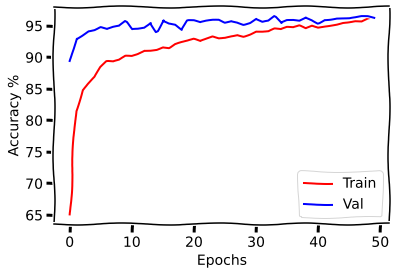

In [7]:
plt.xkcd()
plt.xlabel("Epochs")
plt.ylabel("Accuracy %")
plt.xticks(np.arange(0, 100, step=10))
plt.plot(train_acc_list, 'r', label='Train')
plt.plot(valid_acc_list, 'b', label='Val')
plt.legend()
print(train_acc_list[0],valid_acc_list[0])

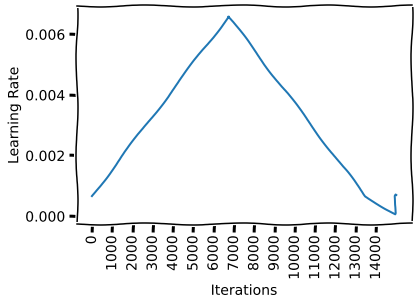

In [8]:
plt.xkcd()
plt.xlabel("Iterations")
plt.ylabel("Learning Rate")
plt.xticks(np.arange(0, len(onecycle.lrs), step=1000), rotation=90)
plt.plot(onecycle.lrs)

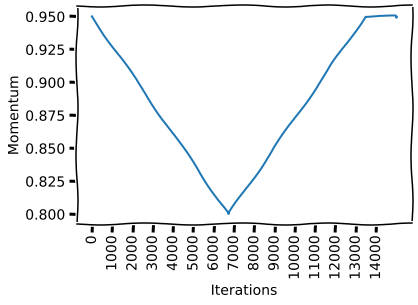

In [9]:
plt.xkcd()
plt.xlabel("Iterations")
plt.ylabel("Momentum")
plt.xticks(np.arange(0, len(onecycle.moms), step=1000), rotation=90)
plt.plot(onecycle.moms)